In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
tawsifurrahman_covid19_radiography_database_path = kagglehub.dataset_download('tawsifurrahman/covid19-radiography-database')

print('Data source import complete.')


Using Colab cache for faster access to the 'covid19-radiography-database' dataset.
Data source import complete.


In [2]:
import tensorflow as tf

# Configure GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

if physical_devices:
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth configured successfully.")
    except RuntimeError as e:
        print(f"Warning: Could not set memory growth: {e}")
else:
    print("No GPU detected. Running on CPU, which may cause issues.")

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth configured successfully.


# ***Importing the necessary libraries***

In [3]:
# General Libraries
import os
import random
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data Handling and Analysis
import numpy as np
import pandas as pd
from collections import Counter
import pickle

# Image Processing
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

# Preprocessing and Machine Learning Utilities
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Pre-trained Models
from tensorflow.keras.applications import ResNet50, EfficientNetB0, InceptionV3, DenseNet121
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

# Transformers
from transformers import TFViTForImageClassification, TFSwinForImageClassification

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ***Loading the dataset and defining the classes***

In [4]:
# Define dataset paths
base_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/'
classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
data = {'image_path': [], 'label': []}

# Load image paths and labels
for class_name in classes:
    class_path = os.path.join(base_path, class_name, 'images')
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        data['image_path'].append(img_path)
        data['label'].append(class_name)

# Create DataFrame
df = pd.DataFrame(data)
print("Dataset Summary:")
print(df.groupby('label').count())

# Save original DataFrame
df.to_csv('dataset.csv', index=False)

Dataset Summary:
                 image_path
label                      
COVID                  3616
Lung_Opacity           6012
Normal                10192
Viral Pneumonia        1345


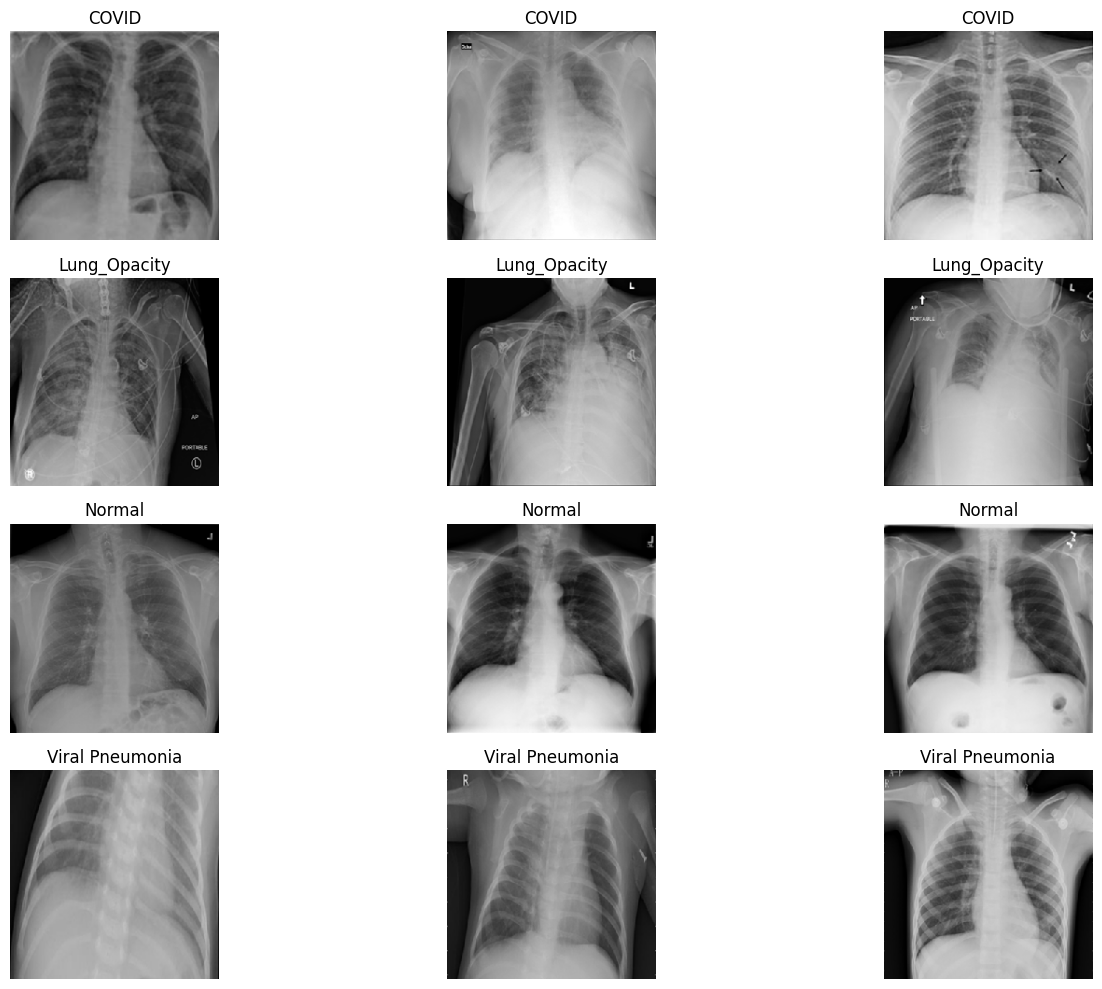

In [5]:
# Function to display sample images
def display_samples(df, classes, samples_per_class=3):
    plt.figure(figsize=(15, 10))

    for i, class_name in enumerate(classes):
        # Get 3 random samples for the class
        class_samples = df[df['label'] == class_name].sample(samples_per_class, random_state=42)

        for j, (_, row) in enumerate(class_samples.iterrows()):
            img = load_img(row['image_path'], target_size=(224, 224))
            plt.subplot(len(classes), samples_per_class, i * samples_per_class + j + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"{class_name}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display 3 samples from each class
display_samples(df, classes, samples_per_class=3)

# ***Data preprocessing and splitting***

- Balancing the dataset to 1250 samples per class
- Encoding the class levels
- Splitting the dataset
- Normalizing the image pixels

In [6]:
# Preprocessing and Balancing
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Balance dataset to 1250 samples per class
samples_per_class = 1250
balanced_df = pd.concat([
    df[df['label'] == class_name].sample(n=samples_per_class, random_state=42)
    for class_name in classes
], axis=0).reset_index(drop=True)

# Encode labels
label_encoder = LabelEncoder()
balanced_df['label_encoded'] = label_encoder.fit_transform(balanced_df['label'])
num_classes = len(label_encoder.classes_)

# Split into train (1000 per class) and test (250 per class)
train_df, test_df = train_test_split(
    balanced_df,
    test_size=250*len(classes),  # 250 samples per class for test
    stratify=balanced_df['label'],
    random_state=42
)

# Function to load and preprocess images
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    return img_array

# Load images and labels
X_train = np.array([load_and_preprocess_image(path) for path in train_df['image_path']])
y_train = to_categorical(train_df['label_encoded'], num_classes=num_classes)
X_test = np.array([load_and_preprocess_image(path) for path in test_df['image_path']])
y_test = to_categorical(test_df['label_encoded'], num_classes=num_classes)

# Data augmentation for training
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# Verify shapes
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

# Save preprocessed data (optional)
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

Training set: (4000, 224, 224, 3), (4000, 4)
Testing set: (1000, 224, 224, 3), (1000, 4)


# ***Visualizing the class distribution***

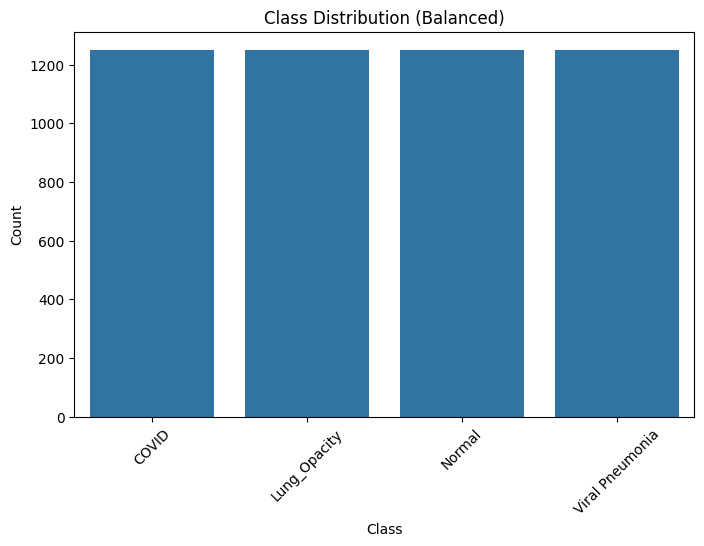

Image dimensions (sample): Widths={299}, Heights={299}


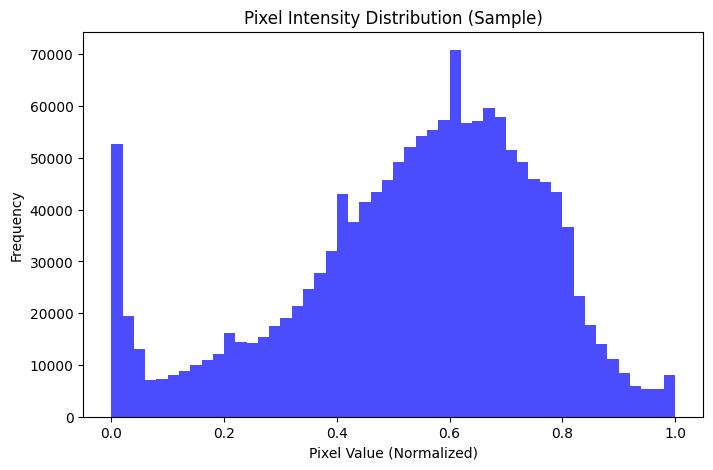

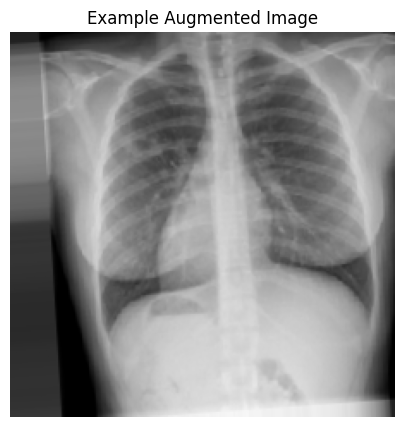

In [7]:
# Exploratory Data Analysis (EDA)
# Class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=balanced_df)
plt.title('Class Distribution (Balanced)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Image dimensions check
dimensions = [Image.open(path).size for path in balanced_df['image_path'].sample(100, random_state=42)]
widths, heights = zip(*dimensions)
print(f"Image dimensions (sample): Widths={set(widths)}, Heights={set(heights)}")

# Pixel intensity distribution
sample_images = [load_and_preprocess_image(path) for path in balanced_df['image_path'].sample(10, random_state=42)]
pixel_values = np.concatenate([img.flatten() for img in sample_images])

plt.figure(figsize=(8, 5))
plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
plt.title('Pixel Intensity Distribution (Sample)')
plt.xlabel('Pixel Value (Normalized)')
plt.ylabel('Frequency')
plt.show()

# Display augmented images (example)
aug_iter = datagen.flow(X_train[:1], y_train[:1], batch_size=1)
aug_img = next(aug_iter)[0][0]

plt.figure(figsize=(5, 5))
plt.imshow(aug_img)
plt.title('Example Augmented Image')
plt.axis('off')
plt.show()

# ***Building and compiling the EfficientNetB0 model***

In [8]:
# Define and build EfficientNetB0 model
effnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze/unfreeze layers
for layer in effnet_base.layers[:-10]:
    layer.trainable = False
for layer in effnet_base.layers[-10:]:
    layer.trainable = True

# Build model architecture
effnet_inputs = Input(shape=(224, 224, 3))
x = effnet_inputs
x = effnet_base(x, training=False)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
effnet_outputs = Dense(num_classes, activation='softmax')(x)
model_effnet = Model(effnet_inputs, effnet_outputs, name='EfficientNetB0')

# Compile model
model_effnet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model_effnet.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,028,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,078,375 (46.08 MB)

 Trainable params: 8,922,036 (34.03 MB)

 Non-trainable params: 3,156,339 (12.04 MB)

# ***Training the model***

In [9]:
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

# Preprocess data for EfficientNetB0
X_train_eff = efficientnet_preprocess(X_train.copy() * 255.0)
X_test_eff = efficientnet_preprocess(X_test.copy() * 255.0)

# Callbacks (same as before)
callbacks_eff = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('efficientnet_best.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# Fit model
history_effnet = model_effnet.fit(
    datagen.flow(X_train_eff, y_train, batch_size=32, seed=42),
    epochs=20,
    validation_data=(X_test_eff, y_test),
    callbacks=callbacks_eff,
    verbose=1
)

# Save history
with open('efficientnet_history.pkl', 'wb') as f:
    pickle.dump(history_effnet.history, f)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 90s 464ms/step - accuracy: 0.6411 - loss: 1.8050 - val_accuracy: 0.8350 - val_loss: 0.4326 - learning_rate: 0.0010
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 314ms/step - accuracy: 0.7930 - loss: 0.5850 - val_accuracy: 0.8390 - val_loss: 0.3809 - learning_rate: 0.0010
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 307ms/step - accuracy: 0.8263 - loss: 0.4716 - val_accuracy: 0.8560 - val_loss: 0.4290 - learning_rate: 0.0010
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 306ms/step - accuracy: 0.8280 - loss: 0.4401 - val_accuracy: 0.8580 - val_loss: 0.4327 - learning_rate: 0.0010
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 308ms/step - accuracy: 0.8346 - loss: 0.4336 - val_accuracy: 0.8680 - val_loss: 0.4118 - learning_rate: 0.0010
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 316ms/step - accuracy: 0.8547 - loss: 0.3583 - val_accuracy: 0.9130 - val_loss: 0.2516 - learning_rate: 2.0000e-04
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 308ms/step - accuracy:

In [10]:
# Evaluate EfficientNetB0 model on test set
effnet_test_loss, effnet_test_accuracy = model_effnet.evaluate(X_test_eff, y_test, verbose=0)
print(f"EfficientNetB0 Test Accuracy: {effnet_test_accuracy:.4f}")
print(f"EfficientNetB0 Test Loss: {effnet_test_loss:.4f}")

EfficientNetB0 Test Accuracy: 0.9210
EfficientNetB0 Test Loss: 0.2076


# ***Classification Report (Model evaluation)***

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step


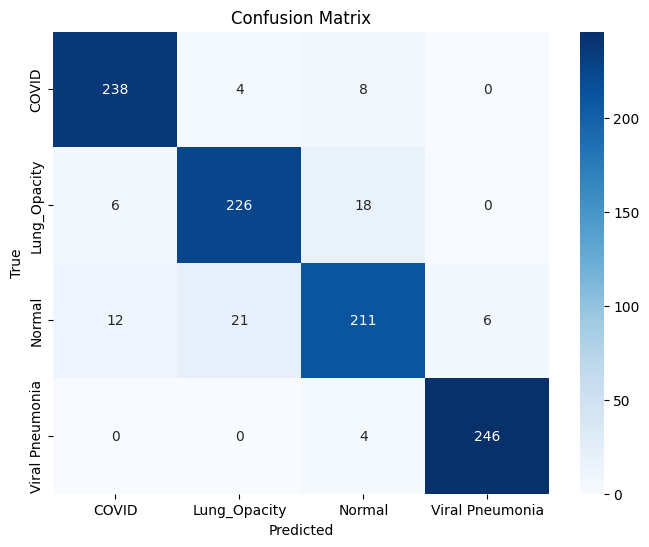

                 precision    recall  f1-score   support

          COVID       0.93      0.95      0.94       250
   Lung_Opacity       0.90      0.90      0.90       250
         Normal       0.88      0.84      0.86       250
Viral Pneumonia       0.98      0.98      0.98       250

       accuracy                           0.92      1000
      macro avg       0.92      0.92      0.92      1000
   weighted avg       0.92      0.92      0.92      1000



In [11]:
y_pred = model_effnet.predict(X_test_eff)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=classes))


# ***Saving the model future implementation***

In [12]:
ModelCheckpoint('efficientnet_best.keras', monitor='val_loss', save_best_only=True)


In [13]:
from tensorflow.keras.models import load_model

# Load the saved EfficientNet model
model = load_model('efficientnet_best.keras')


# ***Predicting the class('COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia') using the saved model***

In [14]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
import numpy as np

# Function to preprocess an image
def preprocess_input_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = efficientnet_preprocess(np.expand_dims(img_array, axis=0))  # Add batch dimension and preprocess
    return img_array


In [15]:
classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [16]:
# Load and preprocess an image
img_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-100.png'  # Replace with your actual image path
processed_img = preprocess_input_image(img_path)

# Predict
pred = model.predict(processed_img)
predicted_class_idx = np.argmax(pred, axis=1)[0]

# Decode label
predicted_label = classes[predicted_class_idx]

print(f"Predicted Label: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Predicted Label: Viral Pneumonia


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


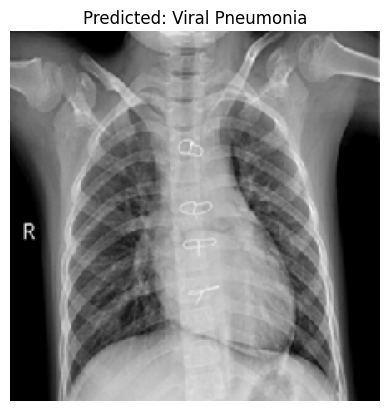

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1002.png'
# Suppose 'img_path' is your input image path
img = image.load_img(img_path, target_size=(224, 224))  # resize if needed
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = efficientnet_preprocess(img_array)

# Predict
prediction = model_effnet.predict(img_array)
predicted_label = classes[np.argmax(prediction)]

# Show the image with prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_label}")
plt.show()


In [18]:
# Preprocess your test data (you already did this earlier)
# X_test_eff

# Get predictions
y_pred_probs = model_effnet.predict(X_test_eff)
y_pred = np.argmax(y_pred_probs, axis=1)  # get predicted class indices
y_true = np.argmax(y_test, axis=1)         # true class indices (assuming y_test is one-hot encoded)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


# ***Checking the misclassified samples***

In [19]:
# Find indices where prediction != true label
misclassified_indices = np.where(y_pred != y_true)[0]

print(f"Total Misclassified Samples: {len(misclassified_indices)}")


Total Misclassified Samples: 79


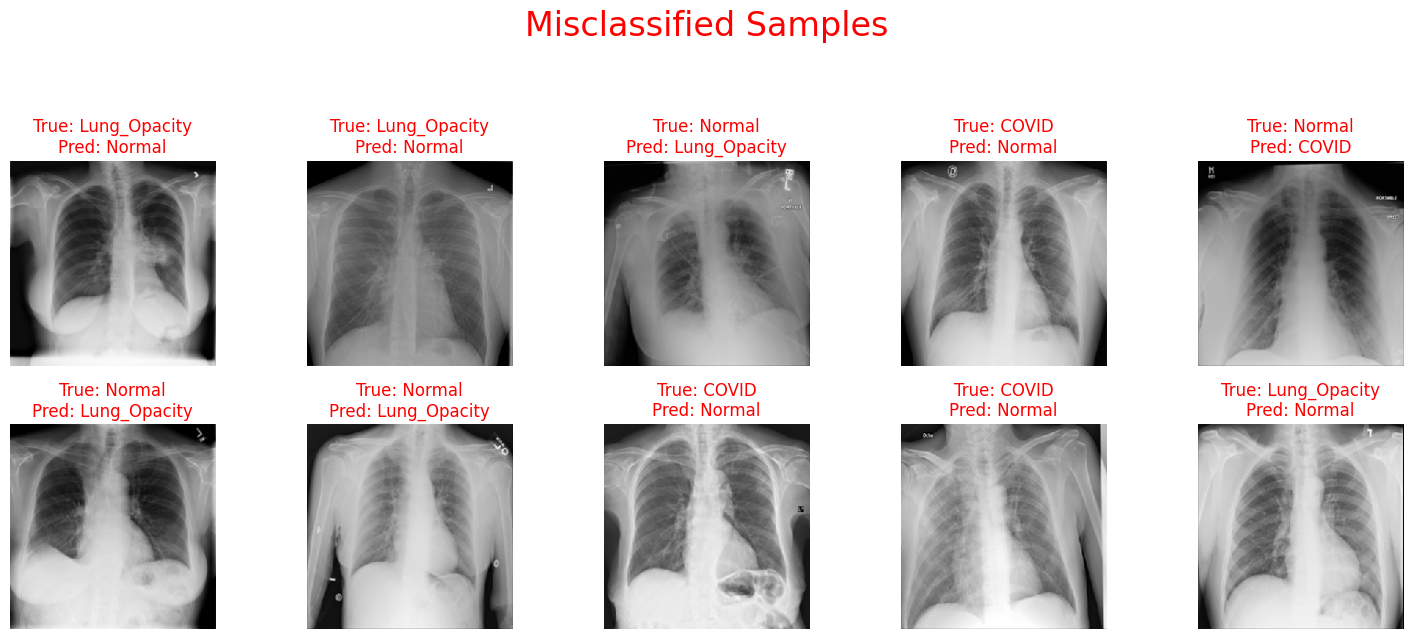

In [20]:
import matplotlib.pyplot as plt

# How many to show
num_to_show = 10

plt.figure(figsize=(15, 15))
plt.suptitle("Misclassified Samples", fontsize=24, color='red')  # <-- Added main title

for i, idx in enumerate(misclassified_indices[:num_to_show]):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_test[idx])  # Original unprocessed image
    true_label = classes[y_true[idx]]
    predicted_label = classes[y_pred[idx]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color='red')
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # <-- leave space for suptitle
plt.show()
